In [1]:
import dolfin as dl
import ufl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
#sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *
sys.path.append( "/Users/irabiel/Documents/Inverse_Problems/ad_diff_diffPara" )
#sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "..") + "/applications/ad_diff/" )
from model_ad_diff import TimeDependentAD, SpaceTimePointwiseStateObservation

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

In [2]:
def v_boundary(x,on_boundary):
    return on_boundary

def q_boundary(x,on_boundary):
    return x[0] < dl.DOLFIN_EPS and x[1] < dl.DOLFIN_EPS

def computeVelocityField(mesh):
    Xh = dl.VectorFunctionSpace(mesh,'Lagrange', 2)
    Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)
    mixed_element = ufl.MixedElement([Xh.ufl_element(), Wh.ufl_element()])
    XW = dl.FunctionSpace(mesh, mixed_element)

    Re = dl.Constant(100)

    g = dl.Expression(('0.0','(x[0] < 1e-14) - (x[0] > 1 - 1e-14)'), degree=1)
    bc1 = dl.DirichletBC(XW.sub(0), g, v_boundary)
    bc2 = dl.DirichletBC(XW.sub(1), dl.Constant(0), q_boundary, 'pointwise')
    bcs = [bc1, bc2]

    vq = dl.Function(XW)
    (v,q) = ufl.split(vq)
    (v_test, q_test) = dl.TestFunctions (XW)

    def strain(v):
        return ufl.sym(ufl.grad(v))

    F = ( (2./Re)*ufl.inner(strain(v),strain(v_test))+ ufl.inner (ufl.nabla_grad(v)*v, v_test)
           - (q * ufl.div(v_test)) + ( ufl.div(v) * q_test) ) * ufl.dx

    dl.solve(F == 0, vq, bcs, solver_parameters={"newton_solver":
                                         {"relative_tolerance":1e-4, "maximum_iterations":100}})

    plt.figure(figsize=(15,5))
    vh = dl.project(v,Xh)
    qh = dl.project(q,Wh)
    nb.plot(nb.coarsen_v(vh), subplot_loc=121,mytitle="Velocity")
    nb.plot(qh, subplot_loc=122,mytitle="Pressure")
    plt.show()

    return v


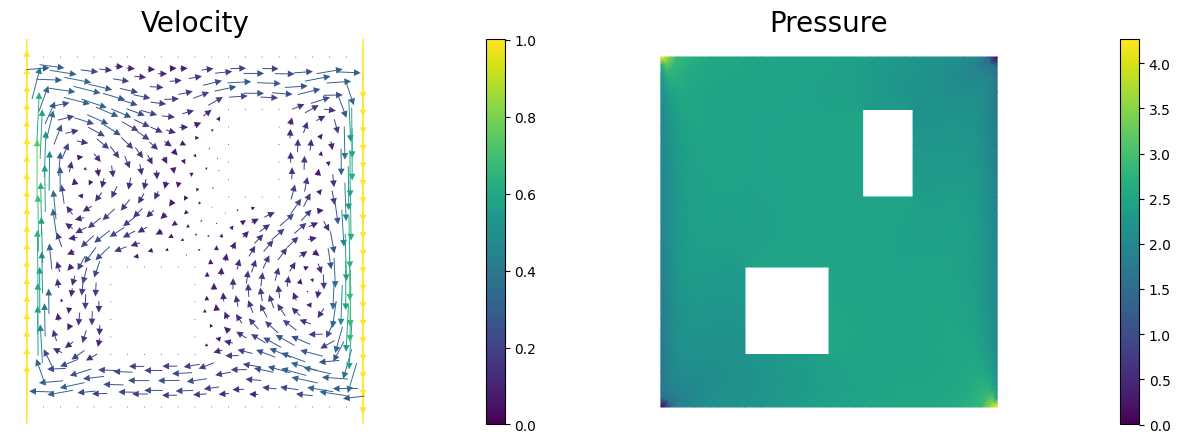

Number of dofs: 2023
Number of dofs: 2023


In [3]:
mesh = dl.refine( dl.Mesh("ad_20.xml") )
wind_velocity = computeVelocityField(mesh)
Vh = [dl.FunctionSpace(mesh, "Lagrange", 1), 
      dl.FunctionSpace(mesh, "Lagrange", 1), 
      dl.FunctionSpace(mesh, "Lagrange", 1)]
print( "Number of dofs: {0}".format( Vh[STATE].dim() ) )
print( "Number of dofs: {0}".format( Vh[PARAMETER].dim() ) )

In [4]:
def true_model(prior):
    noise = dl.Vector()
    prior.init_vector(noise,"noise")
    parRandom.normal(1., noise)
    mtrue = dl.Vector()
    prior.init_vector(mtrue, 0)
    prior.sample(noise,mtrue)
    return mtrue

Number of observation points: 80


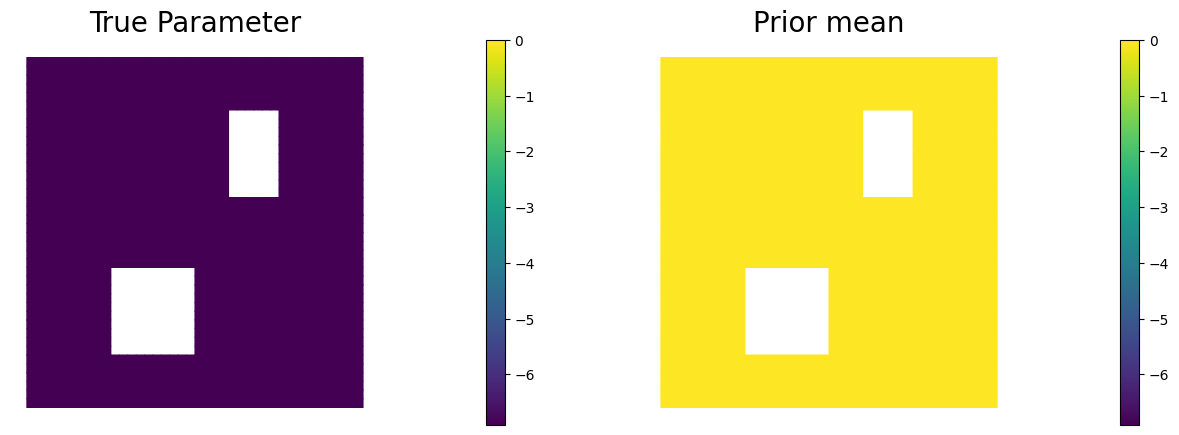

In [13]:
ic_expr = dl.Expression(
    'std::min(0.5,std::exp(-100*(std::pow(x[0]-0.35,2) +  std::pow(x[1]-0.7,2))))',
    element=Vh[STATE].ufl_element())
true_initial_condition = dl.interpolate(ic_expr, Vh[STATE]).vector()

#gamma = 1.
#delta = 8.
#prior = BiLaplacianPrior(Vh[PARAMETER], gamma, delta, robin_bc=True)
#prior.mean = dl.interpolate(dl.Constant(0.25), Vh[PARAMETER]).vector()

gamma = .65
delta = .5

theta0 = 2.
theta1 = .5
alpha  = math.pi/4
    
anis_diff = dl.CompiledExpression(ExpressionModule.AnisTensor2D(), degree = 1)
anis_diff.set(theta0, theta1, alpha)

prior = BiLaplacianPrior(Vh[PARAMETER], gamma, delta, anis_diff, robin_bc=True)
#prior = LaplacianPrior(Vh[PARAMETER], gamma, delta, mean=None)
#prior.mean = dl.interpolate(dl.Constant(0.25), Vh[PARAMETER]).vector()
#mtrue = true_model(prior)
m_expr = dl.Expression(
    'std::log(.001)/std::log(std::exp(1))',
    element=Vh[PARAMETER].ufl_element())
mtrue = dl.interpolate(m_expr, Vh[PARAMETER]).vector()

t_init         = 0.
t_final        = 4.
t_1            = 1.
dt             = .1
observation_dt = .2

simulation_times = np.arange(t_init, t_final+.5*dt, dt)
observation_times = np.arange(t_1, t_final+.5*dt, observation_dt)

targets = np.loadtxt('targets.txt')
print ("Number of observation points: {0}".format(targets.shape[0]) )
misfit = SpaceTimePointwiseStateObservation(Vh[STATE], observation_times, targets)

problem = TimeDependentAD(mesh, Vh, prior, misfit, simulation_times, wind_velocity, True, true_initial_condition)


objs = [dl.Function(Vh[PARAMETER],mtrue),
        dl.Function(Vh[PARAMETER],prior.mean)]
mytitles = ["True Parameter", "Prior mean"]
nb.multi1_plot(objs, mytitles)
plt.show()

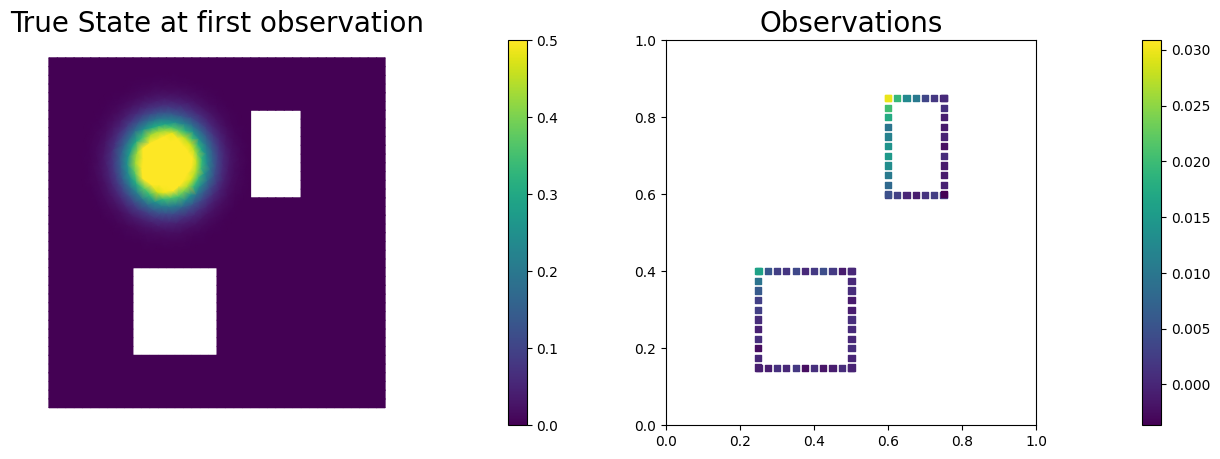

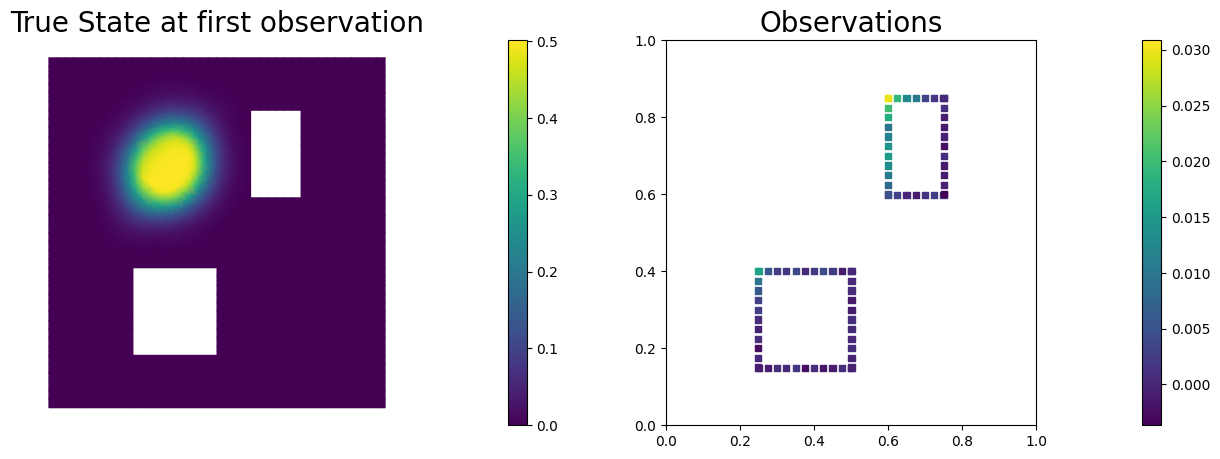

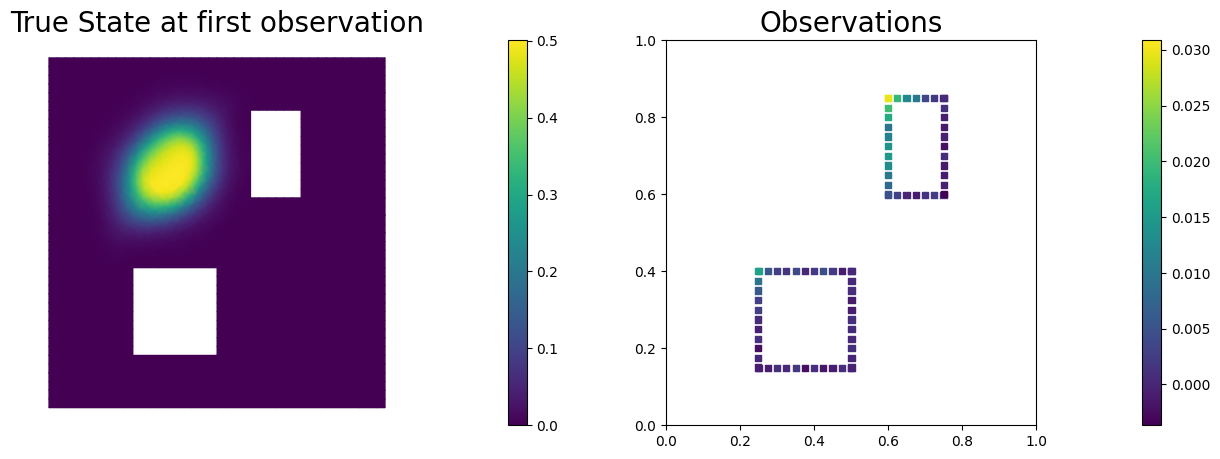

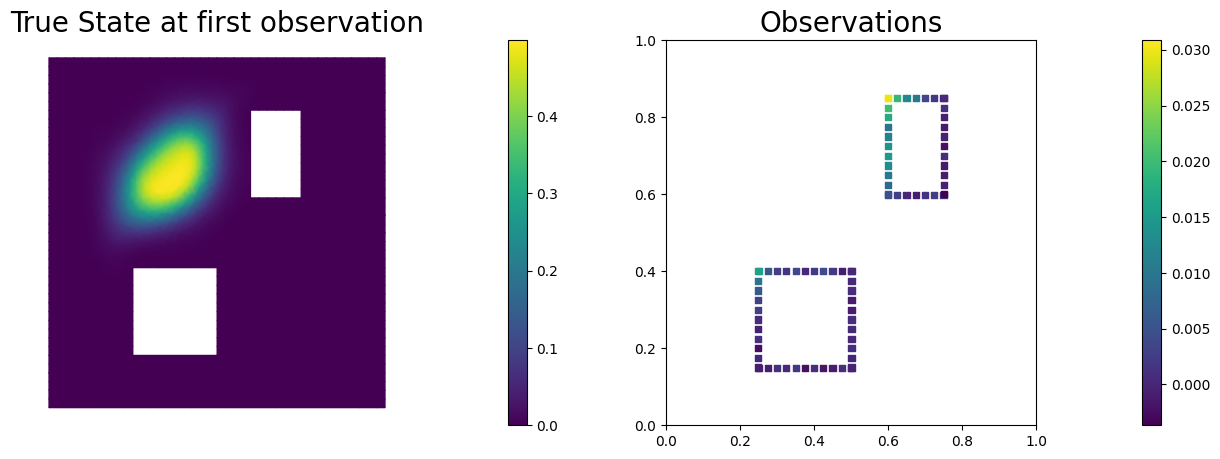

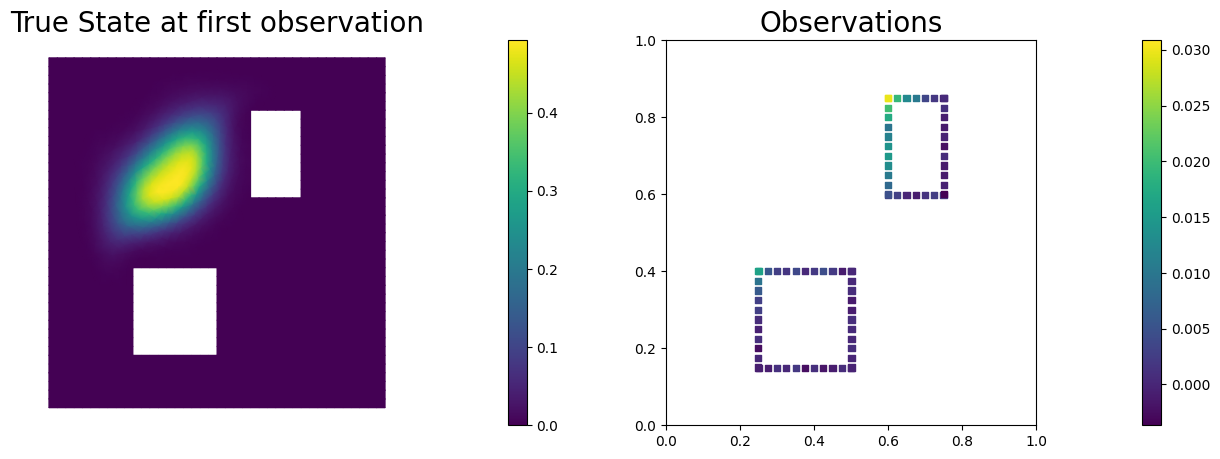

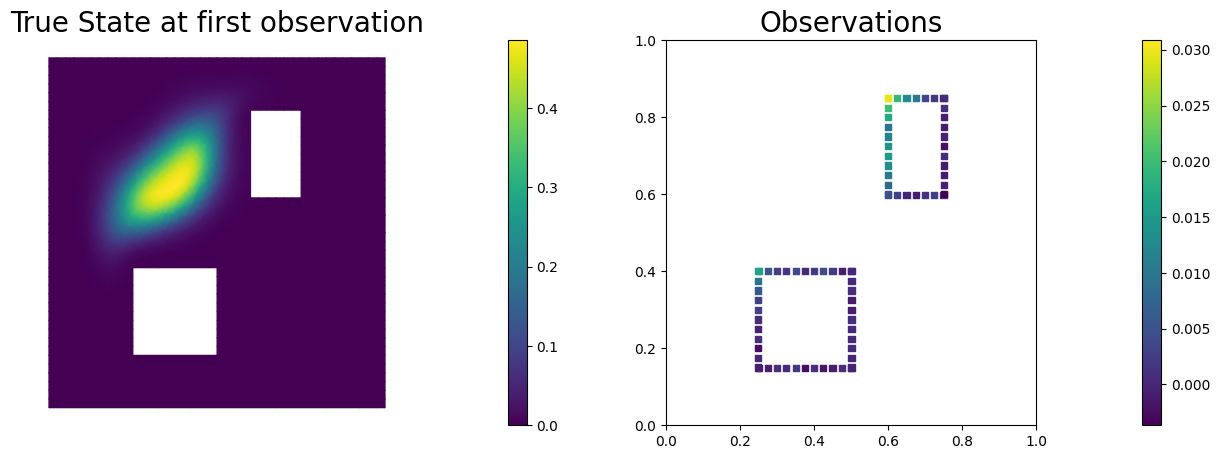

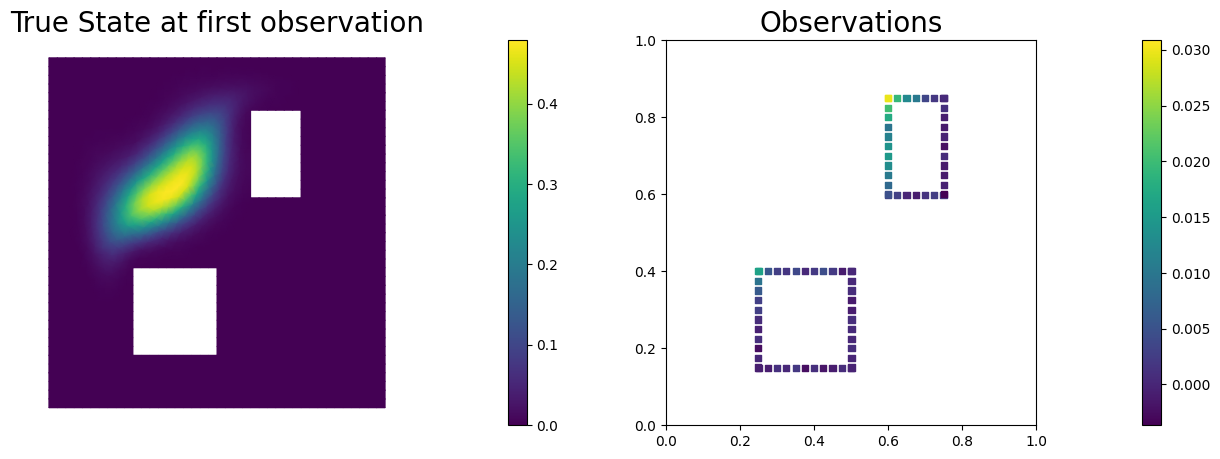

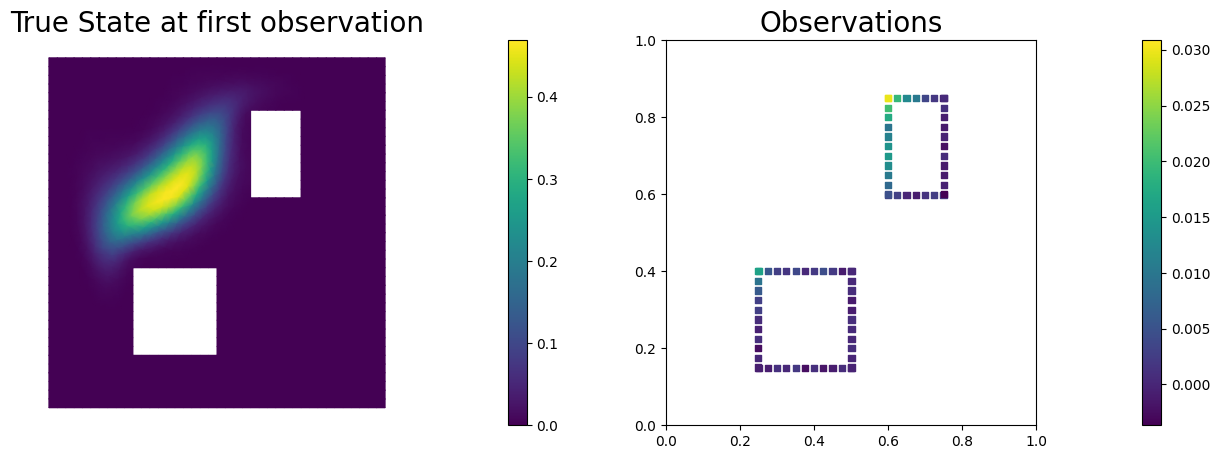

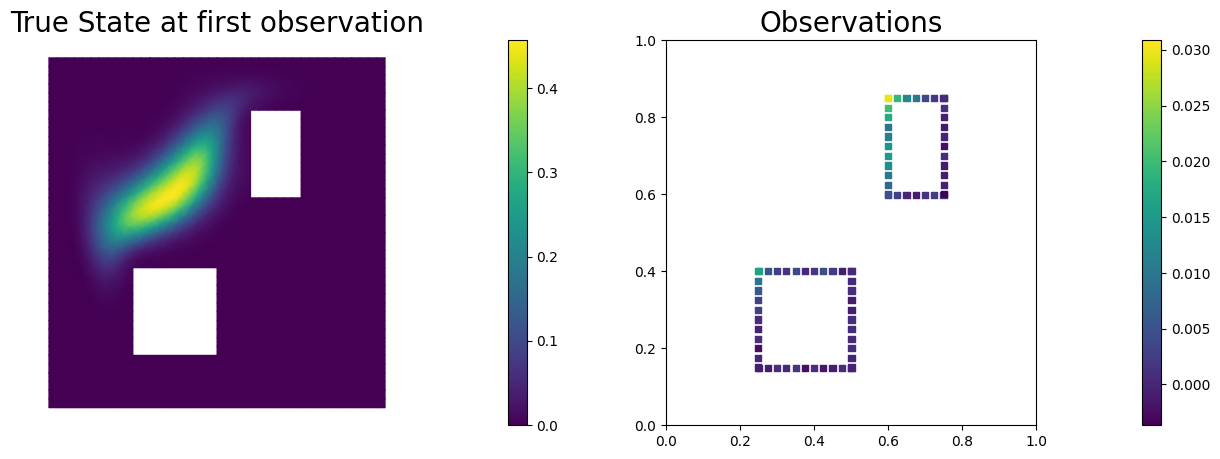

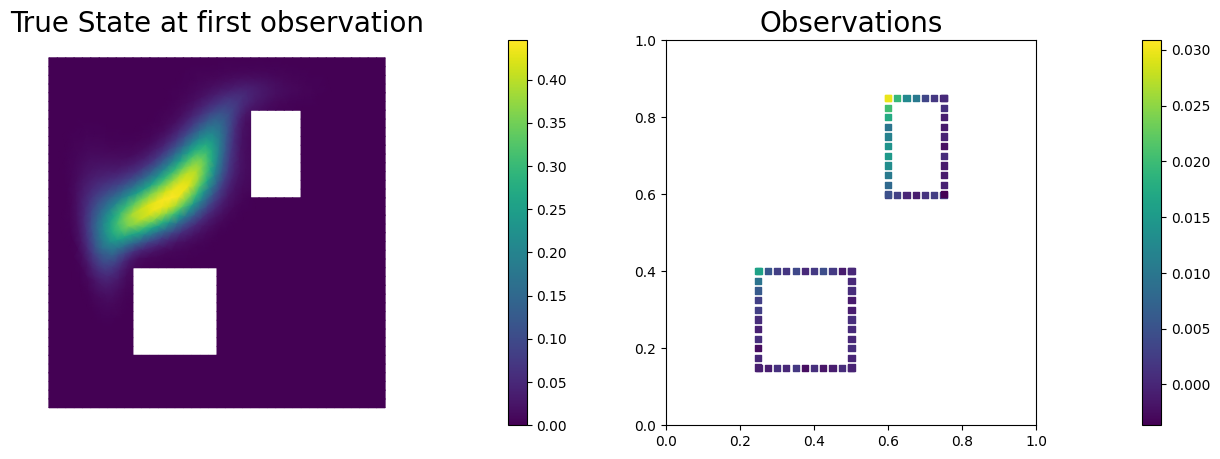

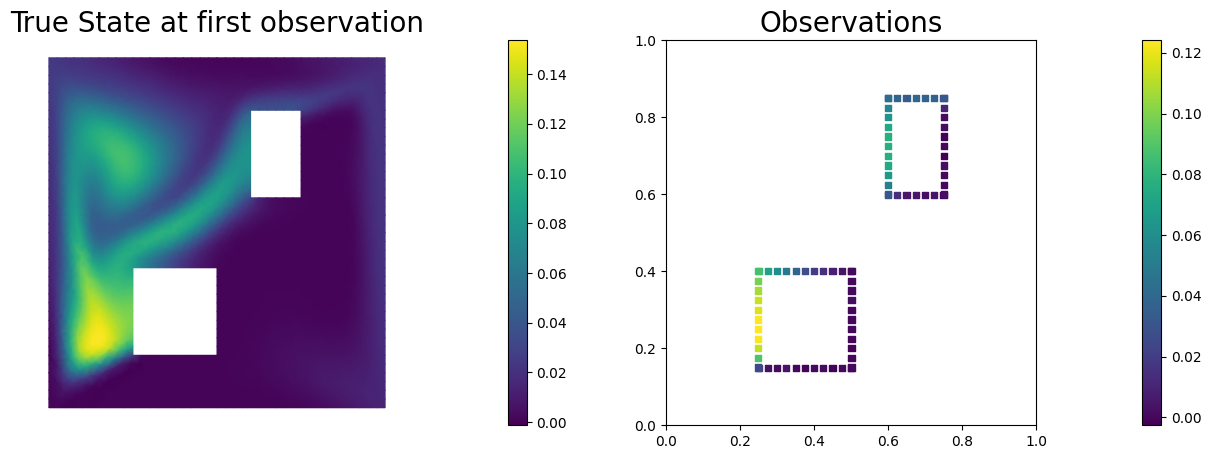

In [14]:
rel_noise = .01
utrue = problem.generate_vector(STATE)
x = [utrue, mtrue, None]
problem.solveFwd(x[STATE], x)
misfit.observe(x, misfit.d)
MAX = misfit.d.norm("linf", "linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev,misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev


for i in range(10):

    plt.figure(figsize=(15,5))
    nb.plot(dl.Function(Vh[STATE], utrue.data[i]), mytitle="True State at first observation", subplot_loc=121)
    nb.plot_pts(targets, misfit.d.data[0], mytitle="Observations", subplot_loc=122)
    plt.show()
    
plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], utrue.data[-1]), mytitle="True State at first observation", subplot_loc=121)
nb.plot_pts(targets, misfit.d.data[-1], mytitle="Observations", subplot_loc=122)
plt.show()

(yy, H xx) - (xx, H yy) =  7.702289094605666e-15


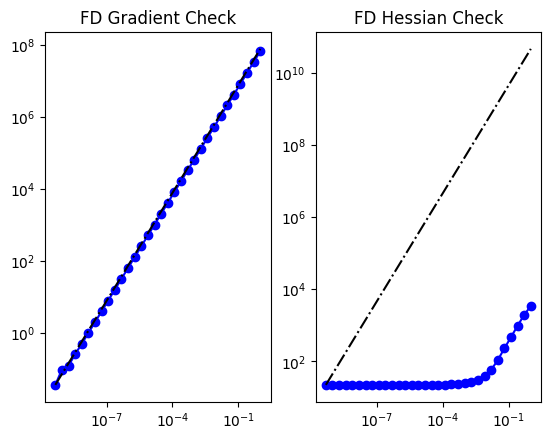

In [15]:
m0 = mtrue.copy()
_ = modelVerify(problem, m0, is_quadratic=False)

In [16]:
[u,m,p] = problem.generate_vector()
problem.solveFwd(u, [u,m,p])
problem.solveAdj(p, [u,m,p])
mg = problem.generate_vector(PARAMETER)
grad_norm = problem.evalGradientParameter([u,m,p], mg)

print( "(g,g) = ", grad_norm)

(g,g) =  1155182.906003302



It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    3.491677e+05    3.491307e+05    3.704183e+01   -8.643196e+03   1.155183e+06   2.500000e-01   5.000000e-01
  2   1    2.882915e+05    2.882481e+05    4.342420e+01   -4.677772e+04   8.955659e+11   1.000000e+00   5.000000e-01
  3   1    1.600414e+05    1.599875e+05    5.389822e+01   -1.084348e+05   1.336774e+12   1.000000e+00   5.000000e-01
  4   1    2.141296e+04    2.134468e+04    6.828324e+01   -1.687944e+05   1.463915e+12   1.000000e+00   5.000000e-01
  5   1    5.771814e+03    5.697855e+03    7.395840e+01   -2.869972e+04   2.542464e+11   1.000000e+00   5.000000e-01
  6   2    3.277263e+03    3.201784e+03    7.547891e+01   -3.602206e+03   2.818755e+10   1.000000e+00   5.000000e-01
  7   1    3.124547e+03    3.048529e+03    7.601838e+01   -2.874671e+02   1.196177e+10   1.000000e+00   5.000000e-01
  8   3    1.408257e+03    1.326719e+03    8.153826e+01   -2.

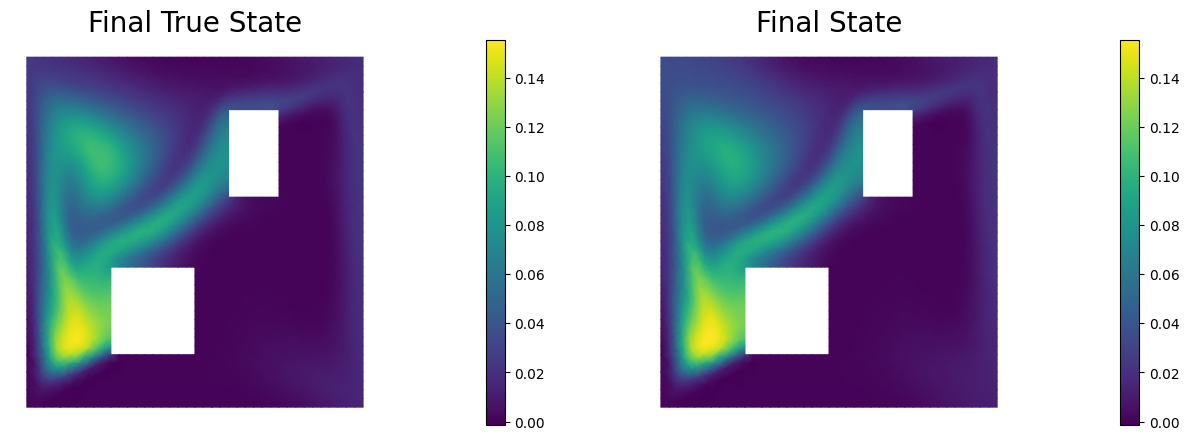

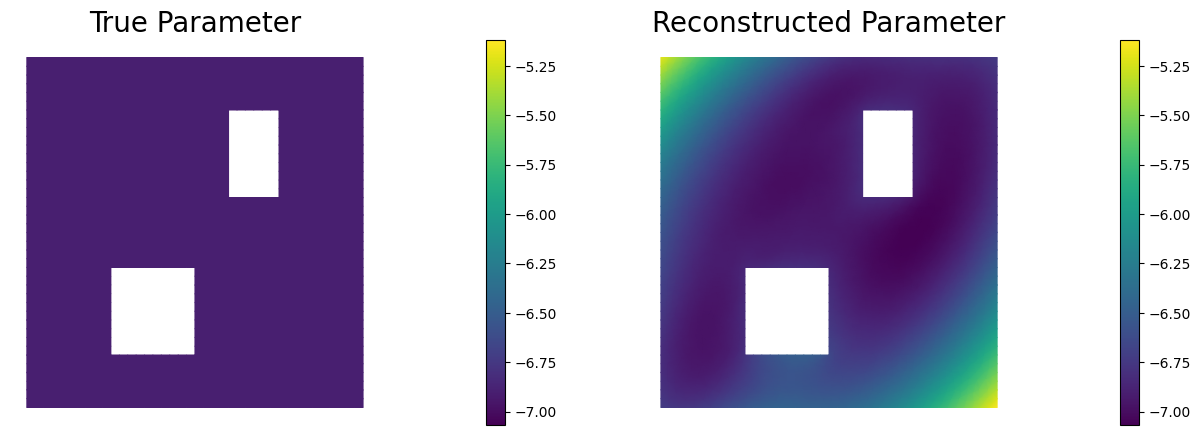

In [17]:
m = prior.mean.copy()
solver = ReducedSpaceNewtonCG(problem)
solver.parameters["rel_tolerance"] = 1e-8
solver.parameters["abs_tolerance"] = 1e-12
solver.parameters["max_iter"]      = 25
solver.parameters["GN_iter"] = 5
solver.parameters["globalization"] = "LS"
solver.parameters["LS"]["c_armijo"] = 1e-4

    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )


u_min = min(utrue.data[-1].min(),x[STATE].data[-1].min()) 
u_max = max(utrue.data[-1].max(),x[STATE].data[-1].max())

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], utrue.data[-1]), mytitle="Final True State", subplot_loc=121, vmin=u_min, vmax=u_max)
nb.plot(dl.Function(Vh[STATE], x[STATE].data[-1]), subplot_loc=122,mytitle="Final State", vmin=u_min, vmax=u_max)
plt.show()

m_min = min(mtrue.min(),x[PARAMETER].min()) 
m_max = max(mtrue.max(),x[PARAMETER].max())

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[PARAMETER], mtrue), subplot_loc=121,mytitle="True Parameter", vmin=m_min, vmax=m_max)
nb.plot(dl.Function(Vh[PARAMETER], x[PARAMETER]), subplot_loc=122,mytitle="Reconstructed Parameter", vmin=m_min, vmax=m_max)
plt.show()

Single Pass Algorithm. Requested eigenvectors: 30; Oversampling 5.


Text(0, 0.5, 'eigenvalue')

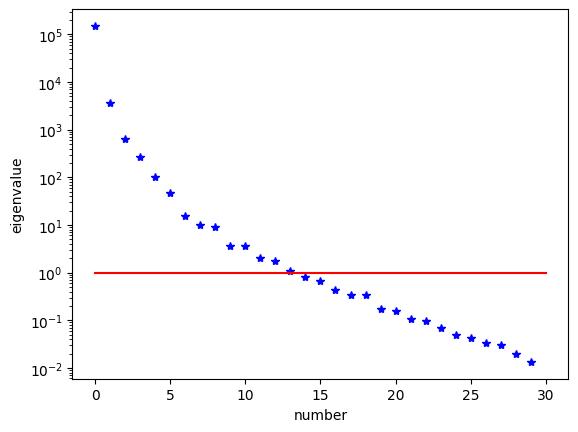

In [18]:
problem.setPointForHessianEvaluations(x, gauss_newton_approx=False)
H = ReducedHessian(problem, misfit_only=True) 

k = 30
p = 5
print( "Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k,p) )
Omega = MultiVector(x[PARAMETER], k+p)
parRandom.normal(1., Omega)
lmbda, V = singlePassG(H, prior.R, prior.Rsolver, Omega, k)

posterior = GaussianLRPosterior( prior, lmbda, V )
posterior.mean = x[PARAMETER]

plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')

#nb.plot_eigenvectors(Vh, V, mytitle="Eigenvector", which=[0,1,2,5,10,20,30,45,60]

Posterior trace 0.0486636; Prior trace 0.322605; Correction trace 0.273941


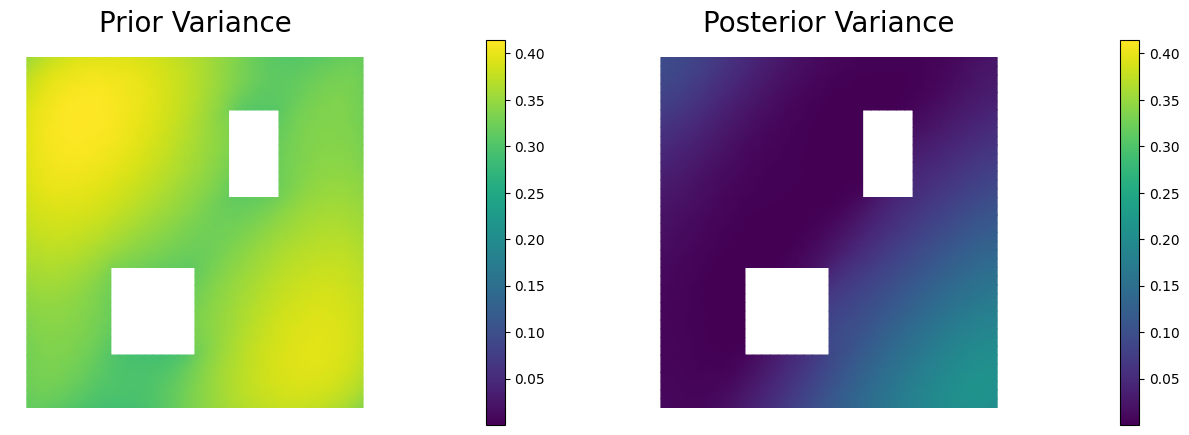

In [19]:
compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Randomized", r=300)
    print( "Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr) )
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance(method="Randomized", r=200)

objs = [dl.Function(Vh[PARAMETER], pr_pw_variance),
        dl.Function(Vh[PARAMETER], post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=False)
plt.show()

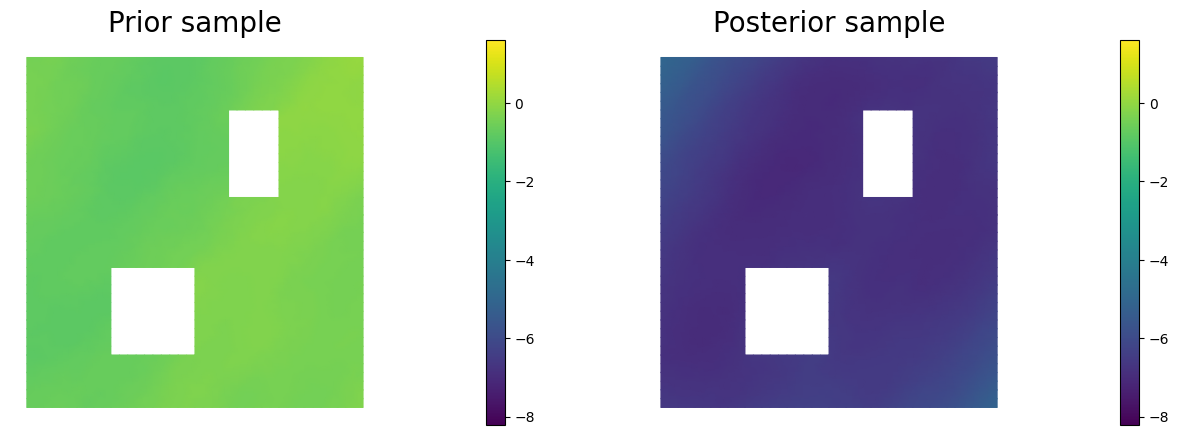

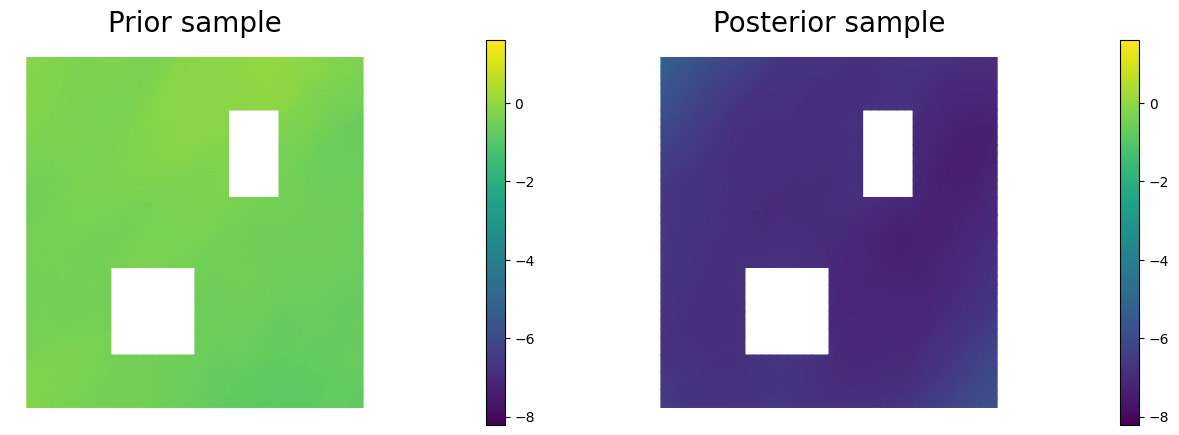

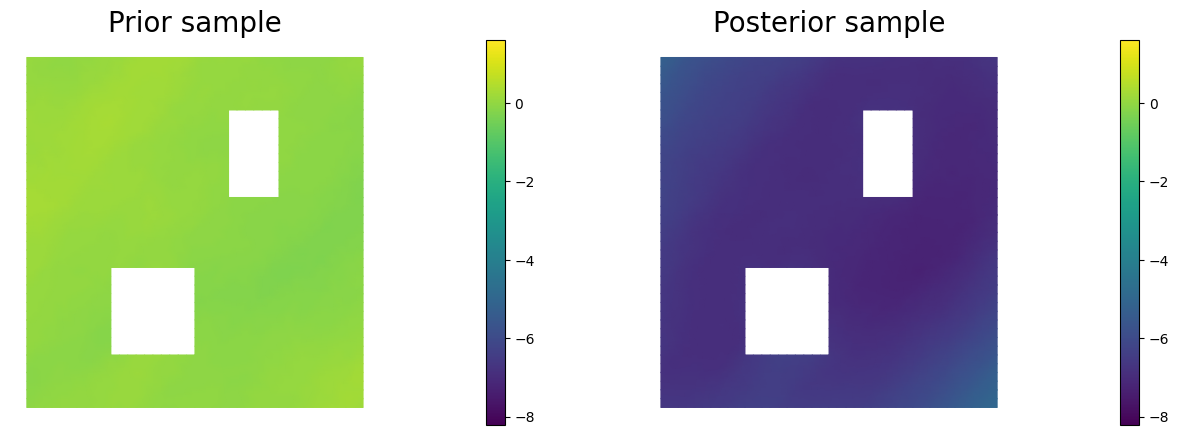

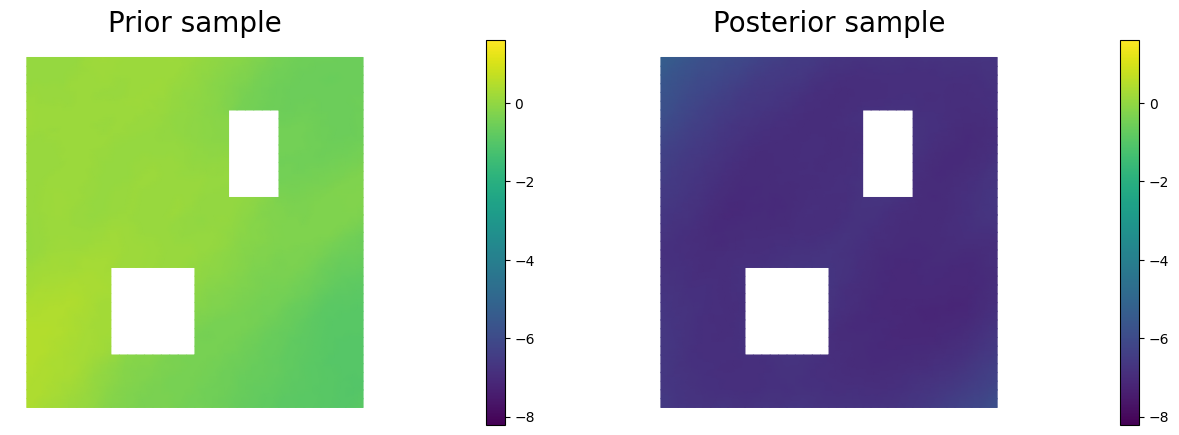

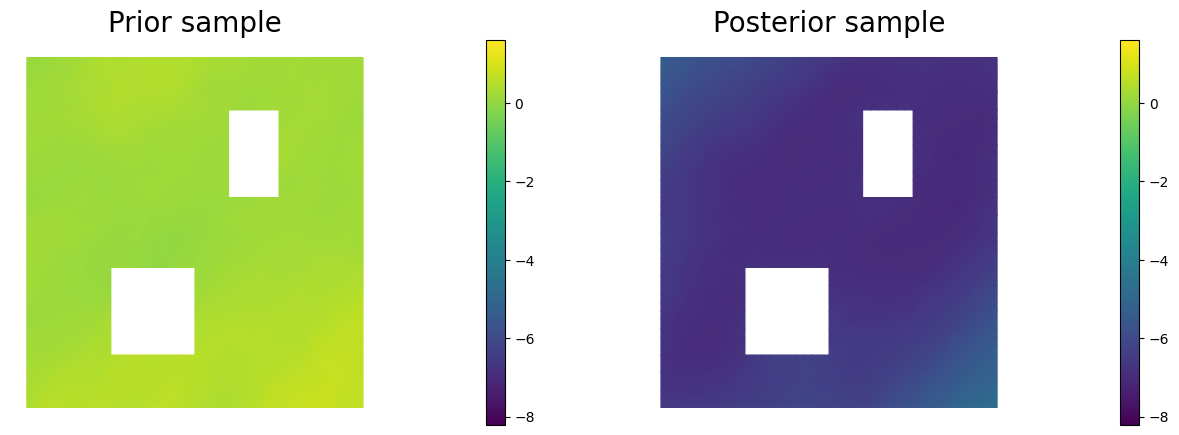

In [20]:
nsamples = 5
noise = dl.Vector()
posterior.init_vector(noise,"noise")
s_prior = dl.Function(Vh[PARAMETER], name="sample_prior")
s_post = dl.Function(Vh[PARAMETER], name="sample_post")

pr_max =  2.5*math.sqrt( pr_pw_variance.max() ) + prior.mean.max()
pr_min = -2.5*math.sqrt( pr_pw_variance.min() ) + prior.mean.min()
ps_max =  2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.max()
ps_min = -2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.min()

for i in range(nsamples):
    parRandom.normal(1., noise)
    posterior.sample(noise, s_prior.vector(), s_post.vector())
    plt.figure(figsize=(15,5))
    nb.plot(s_prior, subplot_loc=121,mytitle="Prior sample", vmin=min(pr_min,ps_min), vmax=max(pr_max,ps_max))
    nb.plot(s_post, subplot_loc=122,mytitle="Posterior sample", vmin=min(pr_min,ps_min), vmax=max(pr_max,ps_max))
    plt.show()